In [1]:
import pennylane as qml
from pennylane import numpy as np

### **Learning Objectives**
- Interpret a quantum circuit as a function
- Find first and higher order derivatives of quantum circuits
- Use optimizers to find extrema od quantum circuit cost fucntions.

In many modern quantum applications, such as Quantum Machine Learning and Quantum Chemistry, quantum circuits are used as mathematical models, or functions. This means we can get creative and do anything with quantum circuit we can usually only do with functions!

How is a quantum circuit a function? Let us look at an example. Consider the circuit

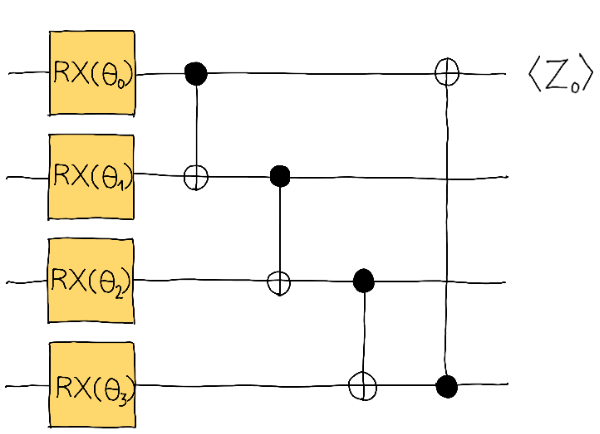

One can think of this circuit as a map
$$
F : \mathbb{R}^{4}  \rightarrow  \mathbb{R}
$$
$$
\left(\theta_{0},\theta_{1},...,\theta_{3}\right) \rightarrow \left<Z_{0}\right>
$$
where the coordinates $(\theta_{0}, ...,{\theta_{3}})$ are the gate parameters and $\left<Z_{0}\right>$ is the expectation value of the PauliZ observable on the first wire.

In general, circuits that are too simple do not yield any mathematical models with interesting applications. To save us some work, PennyLane has some built-in templates that allow us to build expressive quantum circuits. For example `qml.BasicEntanglerLayers` builds a circuit made of layers identical to our circuit above:

(<Figure size 800x500 with 1 Axes>, <Axes: >)

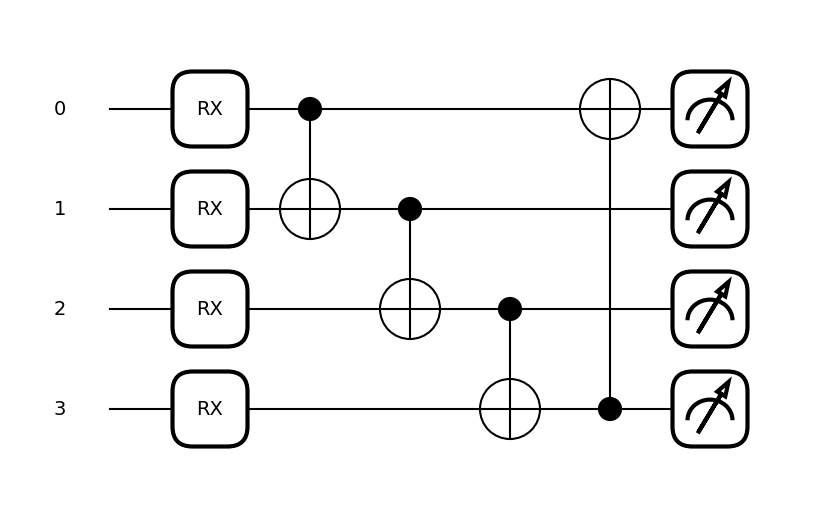

In [2]:
num_wires = 4
device = qml.device("default.qubit", wires = num_wires)
@qml.qnode(device)
def entangler_circuit(weights):
    qml.BasicEntanglerLayers(weights, wires = range(num_wires))
    return [qml.expval(qml.Z(i)) for i in range(num_wires)]
weights = [
    [np.pi, np.pi,np.pi, np.pi]
]
entangler_circuit(weights)
qml.draw_mpl(entangler_circuit,level = "device")(weights)


Now, lets create the same circuit by applying the required gates to each qubit one by one.

[np.float64(-1.0), np.float64(1.0), np.float64(-1.0), np.float64(1.0)]


(<Figure size 800x500 with 1 Axes>, <Axes: >)

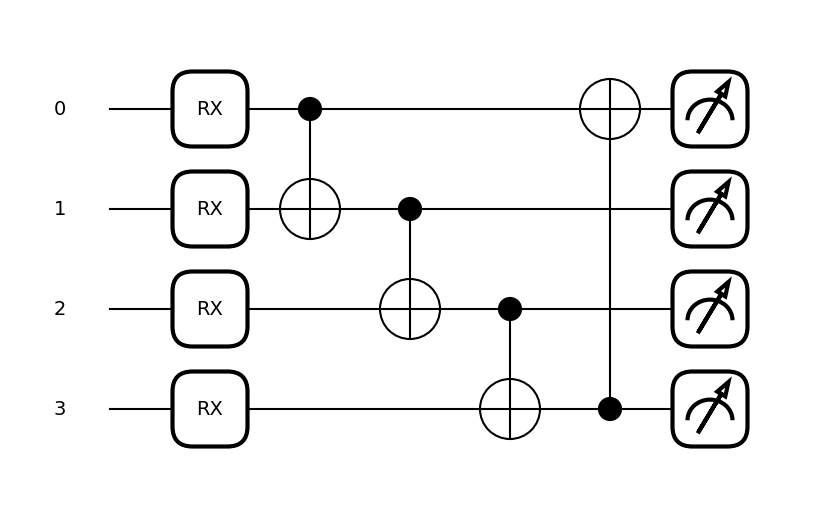

In [3]:
@qml.qnode(device)
def same_entangler_circuit(theta):
    qml.RX(theta,wires = 0)
    qml.RX(theta,wires = 1)
    qml.RX(theta,wires = 2)
    qml.RX(theta,wires = 3)
    qml.CNOT(wires = [0,1])
    qml.CNOT(wires = [1,2])
    qml.CNOT(wires = [2,3])
    qml.CNOT(wires = [3,0])
    return [qml.expval(qml.PauliZ(i)) for i in range(num_wires)]
print(same_entangler_circuit(np.pi))
qml.draw_mpl(same_entangler_circuit)(np.pi)

It means, instead of writting these long codes, we can construct similar circuit by just one line function `qml.BasicEntanglerLayers`. If we want more entanglement between all the qubits, one option is `qml.StronglyEntanglingLayers`, which constructs a circuit of the form,

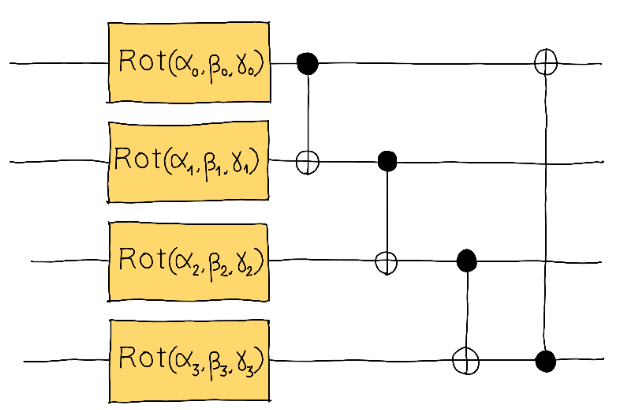

(2, 5, 3)
(<Figure size 1500x600 with 1 Axes>, <Axes: >)


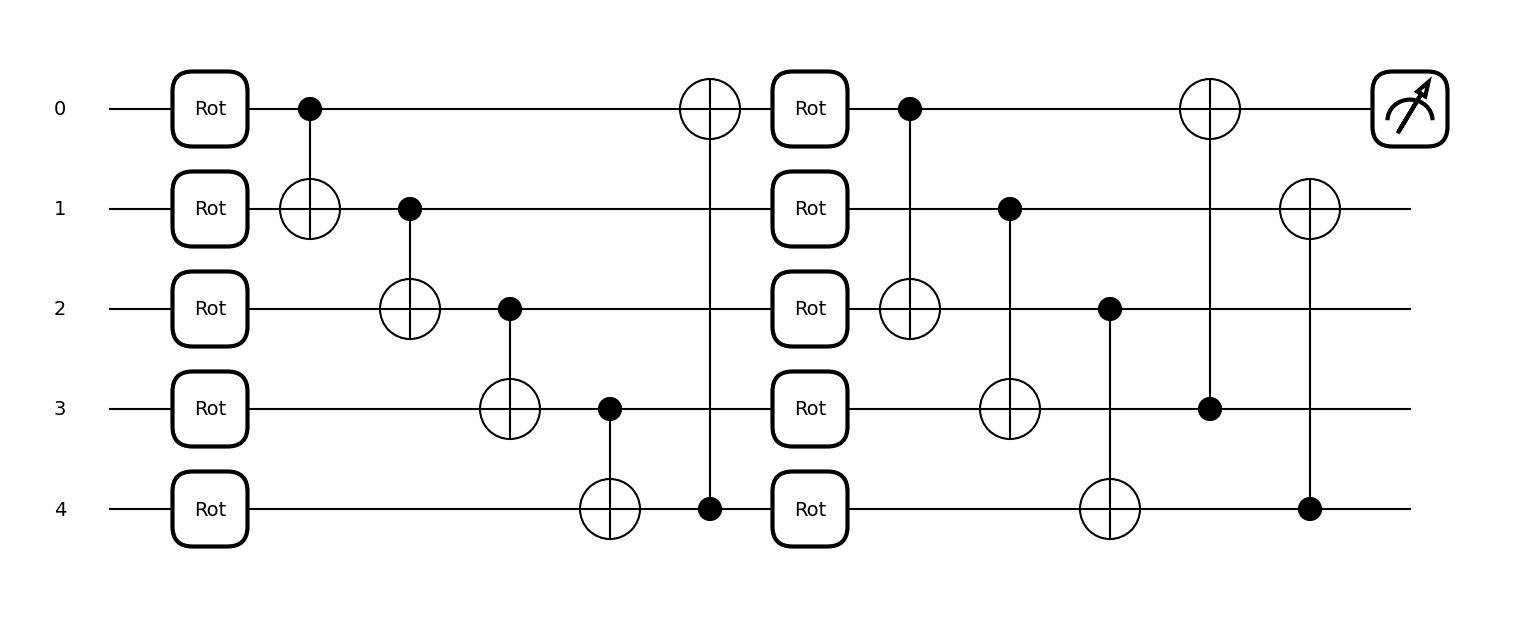

In [15]:
num_wires = 5
device1 = qml.device("default.qubit")
@qml.qnode(device1)
def Strong_Entangling_Layers(weights):
    qml.StronglyEntanglingLayers(weights, wires = range(num_wires))
    return qml.expval(qml.Z(0))
shape = qml.StronglyEntanglingLayers.shape(n_layers = 2, n_wires = 5)
print(shape)
weights = np.random.random(size  = shape)
print(qml.draw_mpl(Strong_Entangling_Layers, level = "device")(weights))

### Gradient of a Circuit
Now that we understand how circuits can be interpreted as mathematical functions, let's try doing with them what we can do with functions! In particular, let's try to find their derivative. This is useful in many optimization-related applications in Quantum Chemistry and Quantum Machine Learning.
Consider again the circuit below,

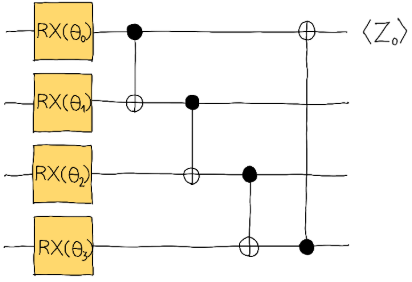

which is a real-valued function F : $\mathbb{R}^{4} \rightarrow \mathbb{R}$. The derivative of this function is encoded in its gradient, which is the vector
$$
\frac{\partial F}{\partial \theta_{i}} = \left(\frac{\partial F}{\partial \theta_{0}}, \frac{\partial F}{\partial \theta_{1}}, \frac{\partial F}{\partial \theta_{2}}, \frac{\partial F}{\partial \theta_{3}}\right)
$$
There are many ways to find this gradient. Most famously, we ahve the **parameter-shift rules**. The simplest parameter shift rule states that, when F represents the expectation value of a quantum circuit with only single-parameter gates
$$
\frac{\partial F}{\partial \theta} = \frac{1}{2}\left[F\left(\theta_{i} + \frac{\pi}{2}\right) - F \left(\theta_{i}  - \frac{\pi}{2}\right)\right]
$$
There exist generalizations for cases in which gates are multi-parametric. Such parameters shift-rules are advantageous since they allow for the computation gradients with little overhead and in an error-robust manner.

There exist generalizations for cases in which gates are multi-parametric. Such parameters shift-rules are advantageous since they allow for the computation gradients with little overhead and in an error-robust manner.

PennyLane can find the gradient of our circuit using `qml.jacobian`. Let's write down our QNode.

(1, 5)
[[0.63001666 0.40941508 0.33162646 0.81651619 0.52141415]]


(<Figure size 900x600 with 1 Axes>, <Axes: >)

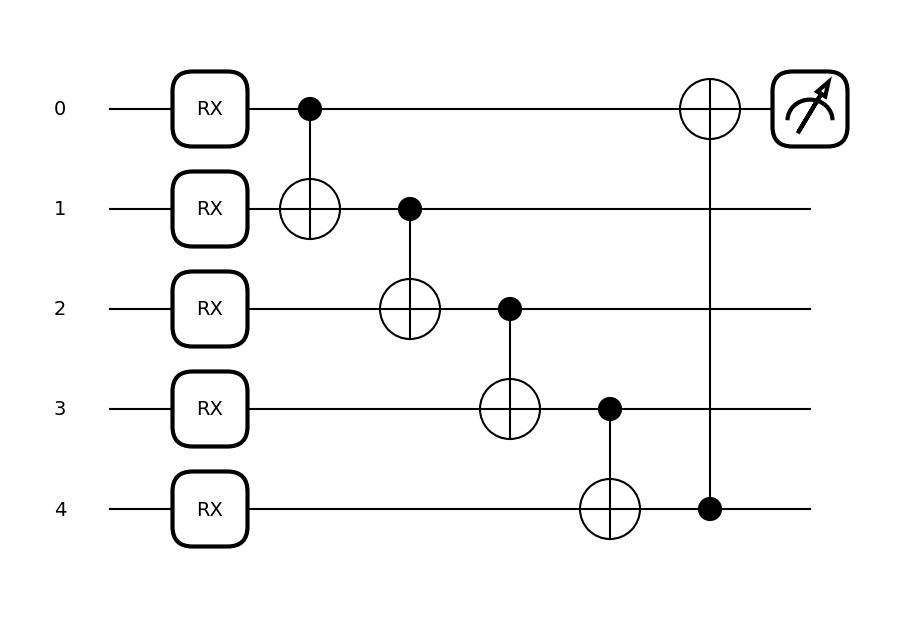

In [37]:
num_wires = 5
num_layers = 1
device2 = qml.device("default.qubit", num_wires)
@qml.qnode(device2)
def compute_gradient(weights):
    qml.BasicEntanglerLayers(weights, wires = range(num_wires))
    return qml.expval(qml.PauliZ(0))
shape = qml.BasicEntanglerLayers.shape(num_layers, num_wires)
print(shape)
weights = np.random.random(size = shape)
print(weights)
qml.draw_mpl(compute_gradient, level = 'device')(weights)

We only want one BasicEntangler layer, so the argument of entangler is a list of the form `[[theta_0, theta_1, theta_2, theta_3]]`. However, we must let PennyLane know that this argument is differentiable. Therefore, we must define this list as a pennylane.numpy list with the `requires_grad` argument set to true, as follows.

In [38]:
test_weights = np.array(weights,requires_grad = True)
print(qml.jacobian(compute_gradient)(test_weights))

[[ 2.77555756e-17 -2.23485114e-01 -1.77343151e-01 -5.48111854e-01
  -2.95847877e-01]]


Unfortunately, jacobian alone does not leverage the power of the `parameter-shift rule`. In the example above, the gradient was calculated using standard numerical methods. To tell PennyLane that we want to use the `parameter-shift rule`, we can change the QNode decorator to  
`@qml.qnode(device2, interface = "autograd", diff_method = "parameter-shift")`
Hence, the full code will be


In [44]:
num_wires = 5
num_layers = 1
device2 = qml.device("default.qubit", num_wires)
@qml.qnode(device2, interface = "autograd", diff_method= "parameter-shift")
def compute_gradient(weights):
    qml.BasicEntanglerLayers(weights, wires = range(num_wires))
    return qml.expval(qml.PauliZ(0))
shape = qml.BasicEntanglerLayers.shape(num_layers, num_wires)
# print(shape)
weights = np.random.random(size = shape, requires_grad = True)
# qml.draw_mpl(compute_gradient, level = 'device')(weights)
print(qml.jacobian(compute_gradient)(weights))

[[ 0.         -0.49890639 -0.11338837 -0.05155765 -0.39496581]]


Sometimes, we may encounter applications in which we want some circuit parameters to be differentiated, while others should remain fixed. This is the reason why the `requires_grad` option is important. For example, let's consider two Basic Entangler layers and differentiate only with respect to the parameters `diff_weights` in the first layer. The parameters `fixed_weights` in the second layer remain constant. Let's also make sure that we use the parameter-shift rule.

In [46]:
n_wires = 4
dev = qml.device("default.qubit", wires = n_wires)

@qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
def entangler_fixed(diff_weights, fixed_weights):
    qml.BasicEntanglerLayers(diff_weights, wires = range(n_wires))
    qml.BasicEntanglerLayers(fixed_weights, wires = range(n_wires))
    return qml.expval(qml.PauliZ(0))

test_diff_weights = np.array([[0.5,0.1,-0.4,0.6]], requires_grad = True)
test_fixed_weights = np.array([[0.1,0.2,0.3,0.4]], requires_grad = False)

print(qml.jacobian(entangler_fixed)(test_diff_weights, test_fixed_weights))

[[-0.30647646  0.06160872  0.         -0.41303853]]


### Jacobian of a Circuit
So far, we have assumed that the measurement of interest is the expectation value of an observable. However, the output of a circuit could be described by more than one component.

For example, if the output of a circuit with *k* wires are the measurement probabilities, the output can be a real-valued vector $\left(F_{0}, ..., F_{m-1}\right)$ with $m = 2^{k}$ components. If the circuit depends on n-gate parameters $\left(\theta_{0},...,\theta_{n-1}\right)$, the circuit can be interpreted as a function
$$
F : \mathbb{R}^{n} \rightarrow \mathbb{R}^{m}
$$
In this case, the derivative of F is represented by the $m \times n$ Jacobian matrix,
$$
J = \frac{\partial \mathbf{F}}{\partial \boldsymbol{\theta}} =
\begin{bmatrix}
\frac{\partial F_0}{\partial \theta_0} & \frac{\partial F_0}{\partial \theta_1} & \cdots & \frac{\partial F_0}{\partial \theta_{n-1}} \\
\frac{\partial F_1}{\partial \theta_0} & \frac{\partial F_1}{\partial \theta_1} & \cdots & \frac{\partial F_1}{\partial \theta_{n-1}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial F_{m-1}}{\partial \theta_0} & \frac{\partial F_{m-1}}{\partial \theta_1} & \cdots & \frac{\partial F_{m-1}}{\partial \theta_{n-1}}
\end{bmatrix}
$$
Each row corresponds to the gradient of one output component with respect to all parameters. Each column shows how one parameter affects all outputs.

[[[-0.1068981  -0.28092683]]

 [[-0.0104579   0.28092683]]

 [[ 0.0104579   0.00397943]]

 [[ 0.1068981  -0.00397943]]]


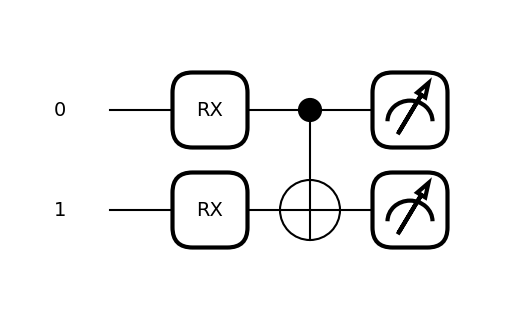

In [74]:
num_wires = 2
num_layers = 1
device2 = qml.device("default.qubit", num_wires)
@qml.qnode(device2, interface="autograd", diff_method="parameter-shift")
def compute_gradient(weights):
    qml.BasicEntanglerLayers(weights, wires = range(num_wires))
    return qml.probs(wires = [0,1]) # just measure probabilities instead of expectation value
shape = qml.BasicEntanglerLayers.shape(num_layers, num_wires)
# print(shape)
weights = np.random.random(size = shape, requires_grad = True)
qml.draw_mpl(compute_gradient, level = 'device')(weights)
print(qml.jacobian(compute_gradient)(weights))

or

In [75]:
dev = qml.device("default.qubit", wires = 2)

@qml.qnode(dev)
def vector_valued_circuit(params):
    qml.RX(params[0], wires = 0)
    qml.CNOT(wires=[0,1])
    qml.RY(params[1], wires = 0)
    return qml.probs(wires = [0,1])
shape = num_wires # only two parameters are required 
sample_params = np.random.random(size = shape, requires_grad = True)
print(qml.jacobian(vector_valued_circuit)(sample_params))

[[-0.14841647 -0.3674188 ]
 [ 0.03153029  0.01273646]
 [-0.03153029  0.3674188 ]
 [ 0.14841647 -0.01273646]]


### Higher Order Derivatives
In optimization applications, we may be interested in finding second derivatives. Going back to scalar-valued circuits
$$
F : \mathbb{R}^{n} \rightarrow \mathbb{R}
$$
we are interested on the stationary points of F, that is, points where the gradient becomes zero. These points may be local or global minima or maxima, saddles, or inflections of F,  We can extract the information on the type of stationary point using the **Hessian matrix** $H[F]$, which contains the second partial derivative of F:
$$
H = \frac{\partial^2 F}{\partial \boldsymbol{\theta}^2} =
\begin{bmatrix}
\frac{\partial^2 F}{\partial \theta_0^2} & \frac{\partial^2 F}{\partial \theta_0 \partial \theta_1} & \cdots & \frac{\partial^2 F}{\partial \theta_0 \partial \theta_{n-1}} \\
\frac{\partial^2 F}{\partial \theta_1 \partial \theta_0} & \frac{\partial^2 F}{\partial \theta_1^2} & \cdots & \frac{\partial^2 F}{\partial \theta_1 \partial \theta_{n-1}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial^2 F}{\partial \theta_{n-1} \partial \theta_0} & \frac{\partial^2 F}{\partial \theta_{n-1} \partial \theta_1} & \cdots & \frac{\partial^2 F}{\partial \theta_{n-1}^2}
\end{bmatrix}
$$

The **second derivative** of a vector-valued function involves computing the second partial derivatives of each output component with respect to all input parameters. This forms a 3D object, but for scalar-valued functions (e.g., expectation value of a single qubit), the second derivative is represented by the **Hessian matrix**. When this matrix is positive definite, we have found a global minimum; and when it's negative definite, we have found a maximum. Looking at specific eigenvalues can inform us about saddle or inflection points. Equivalently, we can calculate the Hessian as the Jacobian of the gradient of
$$
H[F] = J[\nabla F]
$$
We can take advantage of this fact in PennyLane. The `qml.jacobian` of a circuit is also differentiable, so we can find the Hessian of a scalar-valued function by nesting two `qml.jacobian` as shown below. We can take advantage of this fact in PennyLane. The `qml.jacobian` of a circuit is also differentiable, so we can find the Hessian of a scalar-valued function by nesting two `qml.jacobian` as shown below.


In [80]:
dev = qml.device("default.qubit", wires = 2)

@qml.qnode(dev, interface = 'autograd', diff_method = "parameter-shift", max_diff = 2)
def scalar_valued_circuit(params):
  qml.RX(params[0], wires = 0)
  qml.CNOT(wires=[0,1])
  qml.RY(params[1], wires = 0)
  return qml.expval(qml.PauliZ(0))
shape = num_wires
test_params = np.random.random(size = shape, requires_grad = True)
# test_params = np.array([0.7,0.3], requires_grad = True)
qml.jacobian(qml.jacobian(scalar_valued_circuit))(test_params)

array([[-0.87623937,  0.10847505],
       [ 0.10847505, -0.87623937]])

Here, we've chosen the parameter shift rule as the preferred `diff_method`. Setting `max_diff` to 2 informs PennyLane that we will want to differentiate the QNode twice. The default value for `max_diff` is 1, and failing to set it to the number of derivatives we want to apply may produce errors.

In [83]:
dev = qml.device("default.qubit", wires = 2)

@qml.qnode(dev, interface = 'autograd', diff_method = "parameter-shift", max_diff = 2)
def scalar_valued_circuit(params):
  qml.RX(params[0], wires = 0)
  qml.CNOT(wires=[0,1])
  qml.RY(params[1], wires = 0)
  return qml.expval(qml.PauliZ(0))
# shape = num_wires
# test_params = np.random.random(size = shape, requires_grad = True)
# # test_params = np.array([0.7,0.3], requires_grad = True)
# qml.jacobian(qml.jacobian(scalar_valued_circuit))(test_params)

In [84]:
def optimize(cost_function, init_params, steps):
    opt = qml.GradientDescentOptimizer(stepsize = 0.4)
    steps = 100
    params = init_params

    for i in range(steps):
        params = opt.step(cost_function, params)

    return params, cost_function


In [86]:
initial_parameters = np.array([0.7,0.3], requires_grad = True)
optimization_result = optimize(scalar_valued_circuit, initial_parameters, 100)
print(optimization_result)

(tensor([3.14159265e+00, 2.86139596e-17], requires_grad=True), <QNode: device='<default.qubit device (wires=2) at 0x1bdc2a509d0>', interface='autograd', diff_method='parameter-shift'>)
